In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import coorddescent as cd

In [ ]:
#import importlib
#importlib.reload(cd)

# Exercise One

In [2]:
h = pd.read_csv('Hitters.csv', index_col=0)
h.shape

(322, 20)

In [3]:
h[:3]

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Name,,,,,,,,,,,,,,,,,,,,
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A


In [4]:
# remove rows w/ empty values - i think this is only those w/ no salary
h = h.dropna()
h.shape

(263, 20)

In [5]:
# convert categorical vars to dummy variables
h = pd.get_dummies(h)
h.shape

(263, 23)

While the homework doesn't state it specifically, I assume here that we're predicting salary, since that's what we've done previously.

In [44]:
# split into features and the value to predict (x and y)
# scale all features so each col has mean zero and std 1
X_scaled = preprocessing.scale(h.drop('Salary', axis=1))
y = preprocessing.scale(h['Salary'])

(X_scaled.shape, Y.shape)

((263, 22), (263,))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0, test_size=0.25)

In [46]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((197, 22), (66, 22), (197,), (66,))

In [47]:
lambda_vals = [10**k for k in range(-5, 5)]
# increasing max_iter from default of 1000 to ensure convergence (per
# a warning that I'll get when it's the default), also setting 
# normalize to False as we've already standardized the data
lasso = LassoCV(alphas=lambda_vals, normalize=False, fit_intercept=False, max_iter=3000)

lasso.fit(X_train, y_train)
print('Estimated lambda =', lasso.alpha_)
print('Estimated coefficients =', lasso.coef_)
print('Estimated intercept =', lasso.intercept_)

Estimated lambda = 0.0001
Estimated coefficients = [ -5.33797007e-01   5.66035427e-01   1.62925430e-01  -1.41901906e-01
  -4.83896581e-03   3.13685285e-01  -4.58382029e-02  -1.10391792e+00
   1.34739226e+00   2.52457302e-02   6.61019110e-01  -7.06027383e-02
  -3.99815771e-01   1.40184452e-01   1.16576860e-01  -8.26100152e-02
  -5.29900310e-02   5.82724914e-18   1.09757283e-01  -1.26150492e-15
   2.19094767e-02  -0.00000000e+00]
Estimated intercept = 0.0


In [32]:
betas_cyclic = cd.cycliccoorddescent(X_train, y_train, lasso.alpha_, max_iter=1000)
cd.get_final_coefs(betas_cyclic)

array([ -6.71436125e-01,   6.67373167e-01,   1.45827243e-01,
        -9.21500017e-02,   4.89977879e-03,   3.41450123e-01,
        -1.92516029e-01,   3.84318440e-01,   5.99833331e-01,
         1.20784268e-01,   2.05743162e-01,  -2.91677541e-01,
        -4.52519292e-01,   1.34141034e-01,   7.90303312e-02,
        -8.24014901e-02,  -3.97881333e-02,   5.47521371e-15,
         1.26543229e-01,  -5.69031155e-15,   2.16028796e-02,
         0.00000000e+00])

In [33]:
betas_random = cd.randcoorddescent(X_train, y_train, lasso.alpha_, max_iter=1000)
cd.get_final_coefs(betas_random)

array([-0.4645406 ,  0.470844  ,  0.16279535, -0.0588112 , -0.01871804,
        0.29551087, -0.13412544, -0.16284188,  0.39992923, -0.2161443 ,
        0.54446602,  0.33657003, -0.40890427,  0.13149076,  0.08644675,
       -0.08483055, -0.03064628,  0.01537027,  0.13559384,  0.01110617,
       -0.01324571, -0.03372345])

In [48]:
#     obj_values = results.apply(lambda r: obj_func(
#         r.as_matrix(), x, y, lam=lam), axis=1)

In [56]:
obj_values = pd.DataFrame({
    'cyclic': betas_cyclic.apply(lambda r: cd.lasso_objective(r.as_matrix(), X_train, y_train, lasso.alpha_), axis=1),
    'random': betas_random.apply(lambda r: cd.lasso_objective(r.as_matrix(), X_train, y_train, lasso.alpha_), axis=1)
})
obj_values[:3]

,cyclic,random
0,0.843713,0.843713
1,0.709754,0.644459
2,0.706466,0.639518


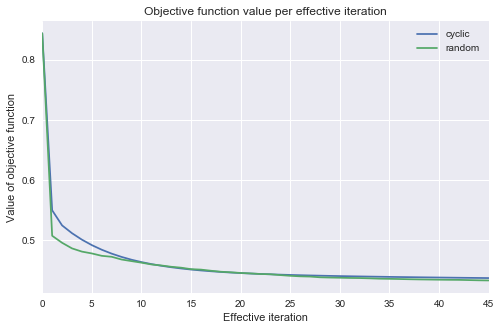

In [76]:
ax = obj_values[::X_train.shape[1]].reset_index(drop=True).plot(title="Objective function value per effective iteration")
ax.set_xlabel("Effective iteration")
ax.set_ylabel("Value of objective function")

**TODO** do code (and of course text) for the last bullet.

# Exercise Two

"a) Generate a simulated data set with 20 observations in each of three classes (i.e. 60 observations total), and 50 variables. Hint: There are a number of functions in numpy that you can use to generate data. One example is the numpy.random.normal() func- tion; numpy.random.uniform() is another option. Be sure to add a mean shift to the observations in each class so that there are three distinct classes."

In [141]:
d = pd.DataFrame(np.vstack([np.random.normal(mean, size=(20,50)) for mean in [0,0.5,1]]))
d.insert(0, 'Class', np.repeat(['A','B','C'], 20))
d[:1]

,Class,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,A,0.688686,-1.097042,-1.061391,0.38873,1.081218,0.109288,-0.809478,0.704436,-0.574833,...,2.657824,-0.904406,-0.110704,1.493636,-0.304674,-0.620203,1.154927,-2.031034,-2.612273,0.604191


"b) Perform PCA on the 60 observations and plot the first two principal component score vectors. Use a different color to indicate the observations in each of the three classes. If the three classes appear separated in this plot, then continue on to part (c). If not, then return to part (a) and modify the simulation so that there is greater separation between the three classes. Do not continue to part (c) until the three classes show at least some separation in the first two principal component score vectors."

**TODO** How to "plot the first two principal component score vectors"? We can't plot actual vectors (i.e., lines and arrow heads) on the actual data, since the data is 50-D. Are we just doing a scatter plot? If yes, what is this showing us? Or, perhaps the seaborn plot below is actually what's being asked for, since the text above says to use a different color?

**TODO** Make sure I figure out how to generate a PDF w/ color. Or, I can update the plot to use different symbols for each class?

In [226]:
d_train_values = d.values[:, 1:51].astype('float')

pca = PCA(2, svd_solver='randomized')
pca.fit(d_train_values)
values_PCA = pca.transform(d_train_values)

In [227]:
pca.components_.shape, values_PCA.shape

((2, 50), (60, 2))

In [228]:
pca.components_[0], pca.components_[1]

(array([ 0.06497832,  0.20085551,  0.1709543 ,  0.16840639,  0.07370657,
         0.10989995,  0.12046219,  0.17797688,  0.12030775,  0.09229532,
         0.1133479 ,  0.07370928,  0.05797848,  0.16529289,  0.04776163,
         0.09448102,  0.24530612,  0.14830914,  0.19091552,  0.12049633,
         0.14781122,  0.19299487,  0.11280109,  0.12136041,  0.01450278,
         0.10783236,  0.04286049,  0.12067063,  0.10769292,  0.17536269,
         0.14745188,  0.17839645,  0.04589662,  0.22927461,  0.17516066,
         0.09713746,  0.13816445,  0.14785754,  0.0719663 ,  0.19242863,
         0.15491612,  0.15976006,  0.17019382,  0.0337986 ,  0.08381657,
         0.2054127 ,  0.17080884,  0.17265158,  0.15268421,  0.13435198]),
 array([ 0.00090058, -0.23515125, -0.07069739,  0.21406853,  0.05479719,
        -0.08526721, -0.22538852, -0.01536416,  0.10560753, -0.38009701,
         0.05294253, -0.15231458, -0.02772412, -0.06550598, -0.11506667,
        -0.05693794, -0.16214888, -0.10326222, -0

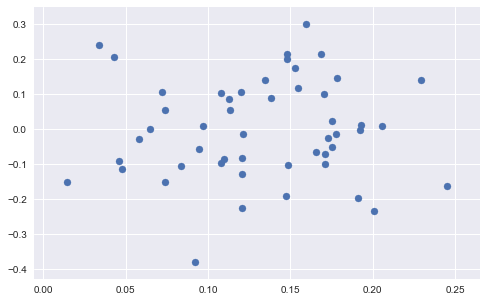

In [229]:
plt.scatter(pca.components_[0], pca.components_[1])

In [230]:
# add PCA values to the dataframe
d['PCA1'] = values_PCA[:, 0]
d['PCA2'] = values_PCA[:, 1]

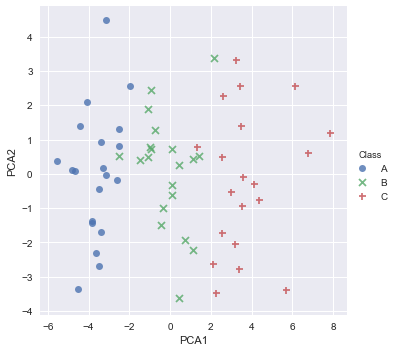

In [231]:
sns.lmplot("PCA1", "PCA2", hue="Class", markers=["o","x","+"], data=d, fit_reg=False)

"c) Perform K-means clustering of the observations with K = 3. How well do the clusters that you obtained in K-means clustering compare to the true class labels? Hint: You can use the value counts() function in the pandas package in Python to compare the true class labels to the class labels obtained by clustering. Be careful how you interpret the results: K-means clustering will arbitrarily number the clusters, so you cannot simply check whether the true class labels and clustering labels are the same."

In [232]:
k = KMeans(n_clusters=3, random_state=0)
k.fit(d_train_values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [233]:
y_kmeans = k.predict(d_train_values)
y_kmeans

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [234]:
pd.Series(y_kmeans).value_counts()

2    22
0    20
1    18
dtype: int64

In [235]:
# add k=3 cluster predicted values to the dataframe
d['K3Cluster'] = y_kmeans

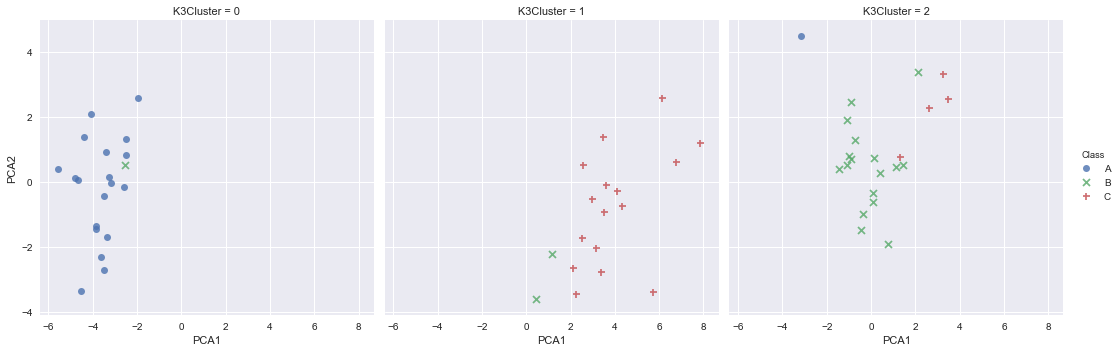

In [236]:
sns.lmplot("PCA1", "PCA2", hue="Class", col="K3Cluster", markers=["o","x","+"], data=d, fit_reg=False)

"d) Perform K-means clustering with K = 2. Describe your results."

In [266]:
def cluster_with_kmeans_and_plot(n_clusters, X, name):
    k = KMeans(n_clusters=n_clusters, random_state=0)
    k.fit(X)
    y_kmeans = k.predict(X)
    d[name] = y_kmeans
    sns.lmplot("PCA1", "PCA2", hue="Class", col=name, markers=["o","x","+"], data=d, fit_reg=False)

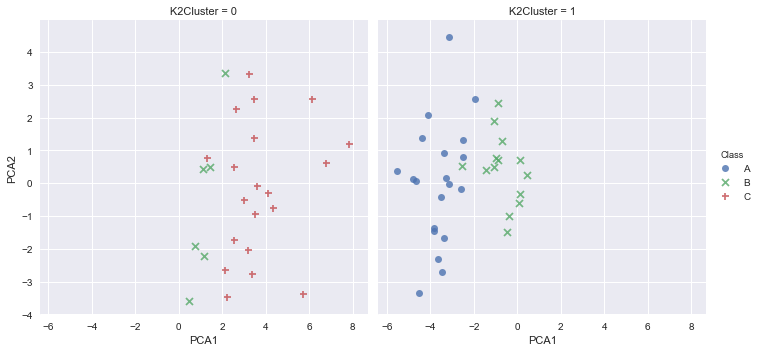

In [267]:
cluster_with_kmeans_and_plot(2, d_train_values, "K2Cluster")

"e) Now perform K-means clustering with K = 4, and describe your results."

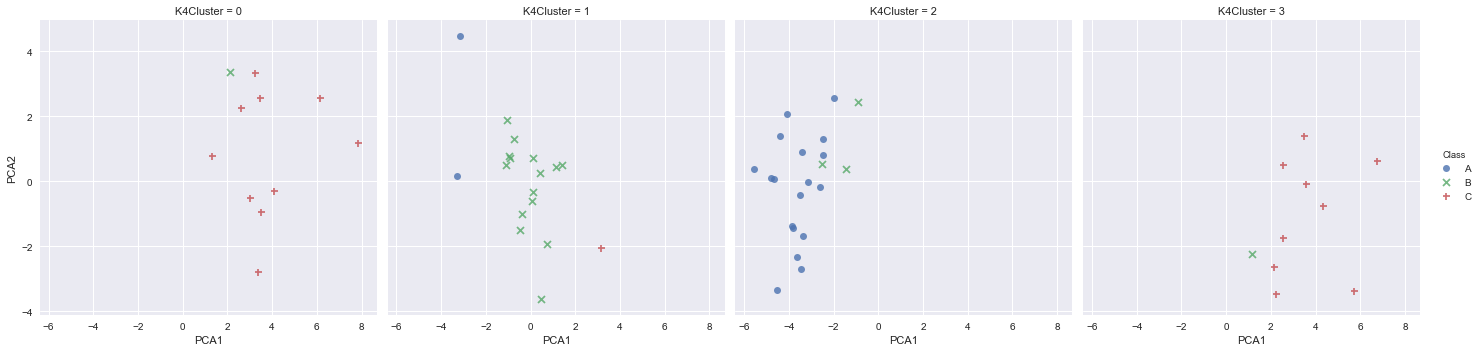

In [268]:
cluster_with_kmeans_and_plot(4, d_train_values, "K4Cluster")

"f) Now perform K-means clustering with K = 3 on the first two principal component score vectors, rather than on the raw data. That is, perform K-means clustering on the 60 × 2 matrix of which the first column is the first principal component score vector, and the second column is the second principal component score vector. Comment on the results."

In [239]:
pca.components_.shape

(2, 50)

**TODO** Not sure what this is asking. Above, I clustered the observations - i.e., I clustered a 60x2 matrix. The first two principal component score vectors are a 2x50 matrix, not 60x2. In the 2x50 matrix, I think, each row is a principal component and each column (50 of them) is a coefficient that adjusts the influence of that particular feature in the particular principal component. How would we cluster based on these?

I suppose we could flip the 2x50 to 50x2 and cluster that way... giving us 50 observations?

In [240]:
k = KMeans(n_clusters=2, random_state=0)
k.fit(pca.components_.T)
y_kmeans = k.predict(pca.components_.T)

In [241]:
y_kmeans

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1], dtype=int32)

"g) Use the StandardScaler function in sklearn.preprocessing to scale each variable to have standard deviation one. Then perform K-means clustering with K = 3 on the scaled data. How do these results compare to those obtained in (b)? Explain."

My note: while we should expect each to have a stddev of roughly one because that's how we defined the random data that we got, it won't be exactly one just because of randomness. Nonetheless, I can see in the actual data that the existing stddevs _are_ pretty close to one, so I don't expect to see much change. Also, I think I'd choose to use the scale function instead of StandardScaler, myself, but I'll do this with StandardScaler since that's what the homework asks for.

In [263]:
[np.std(d_train_values[:,i]) for i in range(0,50)][:5]

[0.92723732033144723,
 1.1733649105501645,
 0.98099349952603887,
 1.0767856581524684,
 0.91708402673927125]

In [244]:
scaler = preprocessing.StandardScaler(with_mean=False, with_std=True).fit(d_train_values)
scaler

StandardScaler(copy=True, with_mean=False, with_std=True)

In [265]:
d_train_values_std = scaler.transform(d_train_values)
[np.std(d_train_values_std[:,i]) for i in range(0,50)][:5]

[0.99999999999999989,
 1.0000000000000002,
 1.0,
 0.99999999999999978,
 0.99999999999999989]

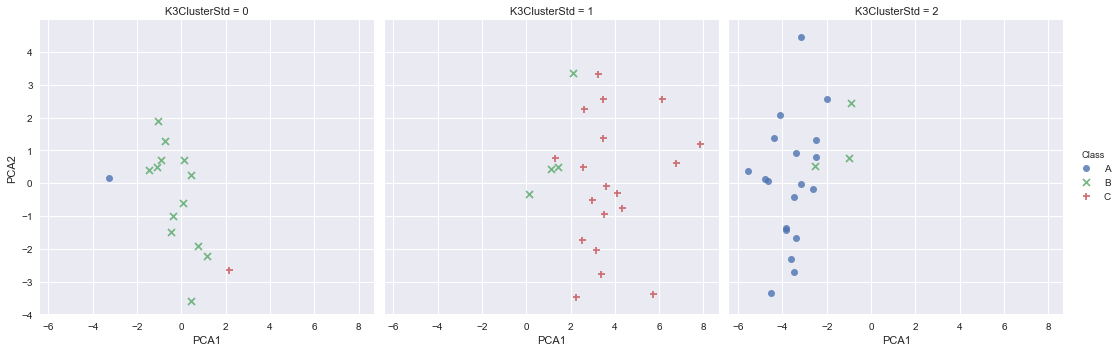

In [269]:
cluster_with_kmeans_and_plot(3, d_train_values_std, "K3ClusterStd")

# Exercise Three

"a) Use the numpy.random.normal() function to generate a predictor X of length n = 100, as well as a noise vector ε of length n = 100."

"b) Generate a response vector Y of length n = 100 according to the model Y =β0 +β1X+β2X2 +β3X3 +ε,
where β0, β1, β2, and β3 are constants of your choice. Here superscripts denote powers of X."

"c) Now fit a lasso model to the simulated data, using X, X2, . . . , X10 as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained."

"d) Now generate a response vector Y according to the model Y = β0 + β7X7 + ε,
and fit a lasso model. Discuss the results obtained."

# Exercise Four

# Exercise Five

* Is there a concept you would love to see covered during the course?
* Is there a concept that has been used multiple times during the course, but you still have no idea what it means?
* Do you feel that you learn better when the course material is covered using slides, or tablet/whiteboard, or numerical illustrations?